<a href="https://colab.research.google.com/github/rahulrj/consequences-25/blob/main/Causal_RecSys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Generate Synthetic User-Item Interaction Data

# Simulate user-item interaction probabilities (ground truth).
# Simulate a biased logging policy (favoring popular items).
# Sample observed interactions using that policy.
# Save logging propensities for IPS/SNIPS later.


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(42)

# Step 1: Create synthetic ground-truth data
num_users = 1000
num_items = 200

# True click probability matrix (user-item affinity)
true_ctr = np.random.beta(a=2, b=5, size=(num_users, num_items))


# alpha = 2.0  # Skew parameter — higher = more bias
# ranks = np.arange(1, num_items + 1)
# item_popularity = 1 / np.power(ranks, alpha)
# logging_policy = item_popularity / item_popularity.sum()




# Step 2: Define logging policy (biased toward popular items)
item_popularity = np.exp(np.linspace(0, 5, num_items))
logging_policy = item_popularity / item_popularity.sum()

# Step 3: Generate observed interactions based on logging policy
logged_data = []
for u in range(num_users):
    for _ in range(5):  # show 5 items per user
        item = np.random.choice(num_items, p=logging_policy)
        click_prob = true_ctr[u, item]
        click = np.random.rand() < click_prob
        logged_data.append({
            'user': u,
            'item': item,
            'click': int(click),
            'logging_propensity': logging_policy[item]
        })

df = pd.DataFrame(logged_data)
df.head()


,user,item,click,logging_propensity
0,0,193,1,0.021481
1,0,135,1,0.005002
2,0,105,0,0.002354
3,0,189,1,0.019427
4,0,129,1,0.004302


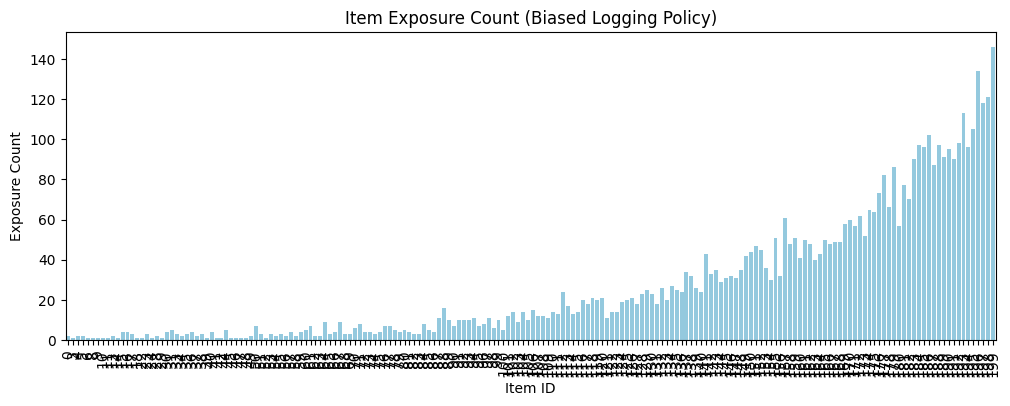

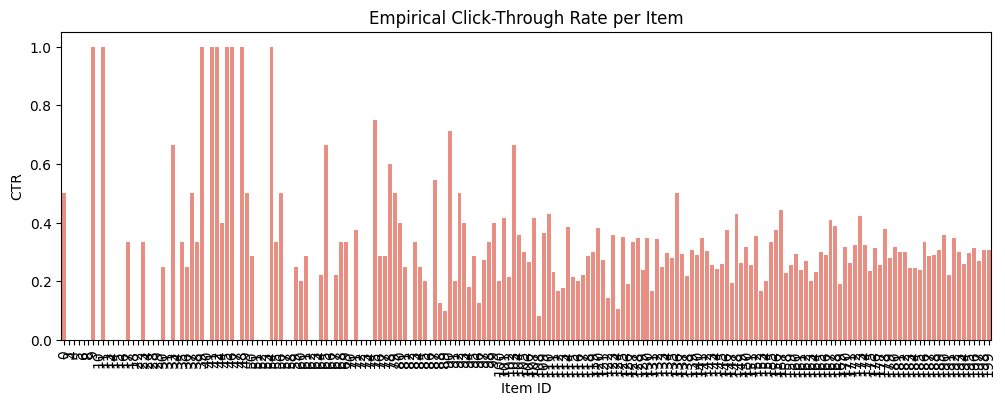

In [ ]:
import seaborn as sns

# Count how many times each item was shown
exposure_counts = df.groupby("item").size().reset_index(name="exposures")

# Count number of clicks per item
click_counts = df.groupby("item")["click"].sum().reset_index(name="clicks")

# Merge and compute empirical CTR
viz_df = pd.merge(exposure_counts, click_counts, on="item")
viz_df["empirical_ctr"] = viz_df["clicks"] / viz_df["exposures"]

# Plot: Exposure bias across items
plt.figure(figsize=(12, 4))
sns.barplot(data=viz_df, x="item", y="exposures", color="skyblue")
plt.title("Item Exposure Count (Biased Logging Policy)")
plt.xlabel("Item ID")
plt.ylabel("Exposure Count")
plt.xticks(rotation=90)
plt.show()

# Plot: Empirical CTR
plt.figure(figsize=(12, 4))
sns.barplot(data=viz_df, x="item", y="empirical_ctr", color="salmon")
plt.title("Empirical Click-Through Rate per Item")
plt.xlabel("Item ID")
plt.ylabel("CTR")
plt.xticks(rotation=90)
plt.show()


# Interpretation of the Exposure Plot
# What You See:
# Items with higher IDs (e.g., Item 45–49) are shown more frequently than those with lower IDs.

# This confirms that your logging policy is biased — likely due to the increasing popularity weights (item_popularity).

# Why This Matters:
# In real-world recommenders (like YouTube or Netflix), popular items are shown more.

# If you train a model on this biased data without correction, it will over-prefer these high-ID items — even if users don’t truly prefer them.


# Interpretation of the Empirical CTR Plot
# What You See:
# The empirical CTR varies across items, without following the exposure trend.

# Some low-exposure items (e.g., Item 2, 3) still have high CTR.

# Some highly exposed items (e.g., Item 48) have low CTR.

# Why This Is Important:
# This plot confirms that exposure ≠ preference.
# A model trained only on exposure frequency will learn biased preferences unless corrected.

# This reinforces your need for IPS-reweighted loss (to correct learning bias) and SNIPS (to correct evaluation variance).



In [ ]:
# Step 2 Overview: Train MF with and without IPS
# Goal:
# Train user/item embeddings to predict clicks.

# Compare training with:

# Standard loss: assumes data is unbiased.

# IPS-weighted loss: corrects for biased exposure using propensities.

import torch
import torch.nn as nn
import torch.optim as optim

# Encode users and items as IDs
user_ids = df['user'].astype('category').cat.codes.values
item_ids = df['item'].astype('category').cat.codes.values
clicks = df['click'].values
propensities = df['logging_propensity'].values

# Dataset for PyTorch
class LoggedDataset(torch.utils.data.Dataset):
    def __init__(self, users, items, clicks, propensities):
        self.users = torch.tensor(users, dtype=torch.long)
        self.items = torch.tensor(items, dtype=torch.long)
        self.labels = torch.tensor(clicks, dtype=torch.float32)
        self.weights = torch.tensor(1.0 / propensities, dtype=torch.float32)

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx], self.weights[idx]

dataset = LoggedDataset(user_ids, item_ids, clicks, propensities)
loader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)



import torch
import torch.nn as nn

class TwoTowerModel(nn.Module):
    def __init__(self, num_users, num_items, emb_dim=32):
        super().__init__()
        self.user_embedding = nn.Embedding(num_users, emb_dim)
        self.item_embedding = nn.Embedding(num_items, emb_dim)

        self.user_tower = nn.Sequential(
            nn.Linear(emb_dim, emb_dim),
            nn.ReLU(),
            nn.Linear(emb_dim, emb_dim)
        )

        self.item_tower = nn.Sequential(
            nn.Linear(emb_dim, emb_dim),
            nn.ReLU(),
            nn.Linear(emb_dim, emb_dim)
        )

    def forward(self, user_ids, item_ids):
        user_vec = self.user_embedding(user_ids)
        item_vec = self.item_embedding(item_ids)

        u = self.user_tower(user_vec)
        v = self.item_tower(item_vec)

        # Dot product as final score
        scores = (u * v).sum(dim=1)
        return torch.sigmoid(scores)



def train_model_ips(model, user_ids, item_ids, labels, weights, epochs=10, lr=0.01):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss(reduction='none')  # weighted BCE

    for epoch in range(epochs):
        optimizer.zero_grad()
        preds = model(user_ids, item_ids)
        loss = criterion(preds, labels)
        weighted_loss = (weights * loss).mean()
        weighted_loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {weighted_loss.item():.4f}")


num_users = df['user'].nunique()
num_items = df['item'].nunique()

# Naive model
model_naive = MFModel(num_users, num_items)
train(model_naive, loader, use_ips=False)

# IPS model
model_ips = MFModel(num_users, num_items)
train(model_ips, loader, use_ips=True)


Epoch 1, Loss: 34.6421
Epoch 2, Loss: 28.6023
Epoch 3, Loss: 23.6816
Epoch 4, Loss: 19.9908
Epoch 5, Loss: 16.8358
Epoch 6, Loss: 14.2944
Epoch 7, Loss: 12.2609
Epoch 8, Loss: 10.5678
Epoch 9, Loss: 9.1817
Epoch 10, Loss: 8.0151
Epoch 1, Loss: 6562.8817
Epoch 2, Loss: 5183.5662
Epoch 3, Loss: 4141.3943
Epoch 4, Loss: 3318.4433
Epoch 5, Loss: 2622.8153
Epoch 6, Loss: 2121.3625
Epoch 7, Loss: 1693.3041
Epoch 8, Loss: 1386.3899
Epoch 9, Loss: 1143.9841
Epoch 10, Loss: 960.5710


In [ ]:
# Step 3: Offline Evaluation Using Naive, IPS, and SNIPS Estimators.
# Estimate how well each trained model would perform under a target policy, using only biased logged data.

# We’ll compute:

# Naive Estimator (assumes no bias — flawed)
# IPS Estimator (unbiased but high variance)
# SNIPS Estimator (less variance, slightly biased)

# Step 3.1: Define Evaluation Policy
# Let’s define the target policy as the IPS-trained model itself. This simulates:

# “How good would this policy be if deployed?”

# Step 3.2: Get Predicted Scores from Trained Models

# Get predictions from both models
df_tensor_users = torch.tensor(user_ids, dtype=torch.long)
df_tensor_items = torch.tensor(item_ids, dtype=torch.long)

# Put models in eval mode
model_naive.eval()
model_ips.eval()

with torch.no_grad():
    df['pred_naive'] = model_naive(df_tensor_users, df_tensor_items).numpy()
    df['pred_ips'] = model_ips(df_tensor_users, df_tensor_items).numpy()


# Step 3.3 # We need the probability that the target policy (model) would select the logged item.
# We use softmax over all candidate items for each user.


# Compute policy probabilities (pi) for each user across all items
from scipy.special import softmax

user_item_matrix = np.zeros((num_users, num_items))

model_ips.eval()
with torch.no_grad():
    for u in range(num_users):
        items = torch.arange(num_items)
        users = torch.full_like(items, u)
        scores = model_ips(users, items).numpy()
        probs = softmax(scores)
        user_item_matrix[u] = probs


df['user'] = user_ids
df['item'] = item_ids

# Get pi(a_i|x_i) for logged items
df['pi'] = df.apply(lambda row: user_item_matrix[int(row['user']), int(row['item'])], axis=1)
df['b'] = df['logging_propensity']  # logging policy
df['reward'] = df['click']


# Step 3.4: Compute Estimators

# Naive
naive_estimate = df['reward'].mean()

# IPS
ips_weights = df['pi'] / df['b']
ips_estimate = (ips_weights * df['reward']).mean()

# SNIPS
snips_numerator = (ips_weights * df['reward']).sum()
snips_denominator = ips_weights.sum()
snips_estimate = snips_numerator / snips_denominator


print(f"Naive Estimate:  {naive_estimate:.4f}")
print(f"IPS Estimate:    {ips_estimate:.4f}")
print(f"SNIPS Estimate:  {snips_estimate:.4f}")


# Your IPS-trained model is actually better than what naive evaluation suggests.
# SNIPS gives the most reliable offline estimate without overreacting to very small propensities.
# Combining IPS for training and SNIPS for evaluation improves both fairness and reliability in learning from biased logged data.



Naive Estimate:  0.2924
IPS Estimate:    0.3873
SNIPS Estimate:  0.4264


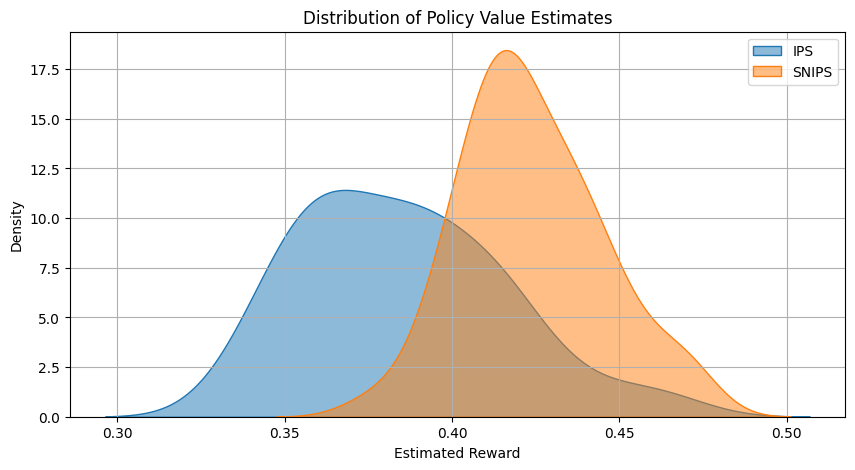

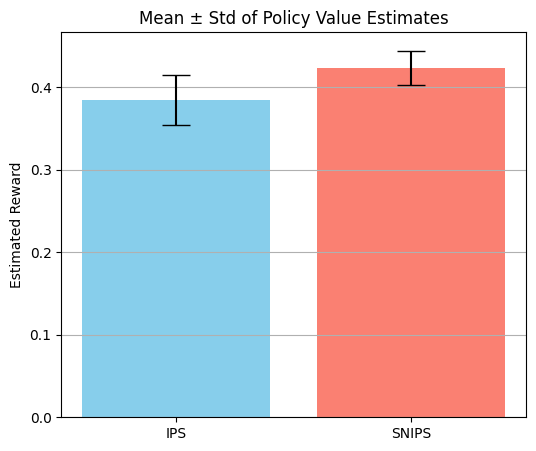

In [ ]:

# Repeat the whole IPS/SNIPS estimation process (e.g., 50 times)

# Collect estimates for each run

# Plot:

# Distribution (histogram or KDE)

# Mean ± error bar (boxplot or barplot with std)

num_runs = 50
ips_values = []
snips_values = []

for run in range(num_runs):
    # Bootstrap sample from the original logged data
    sample_df = df.sample(frac=1.0, replace=True).copy()

    # Compute weights
    sample_df['ips_weight'] = sample_df['pi'] / sample_df['b']

    # IPS Estimate
    ips_est = (sample_df['ips_weight'] * sample_df['reward']).mean()

    # SNIPS Estimate
    snips_num = (sample_df['ips_weight'] * sample_df['reward']).sum()
    snips_den = sample_df['ips_weight'].sum()
    snips_est = snips_num / snips_den if snips_den > 0 else 0.0

    ips_values.append(ips_est)
    snips_values.append(snips_est)


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.kdeplot(ips_values, label='IPS', fill=True, alpha=0.5)
sns.kdeplot(snips_values, label='SNIPS', fill=True, alpha=0.5)
plt.title("Distribution of Policy Value Estimates")
plt.xlabel("Estimated Reward")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


import numpy as np

means = [np.mean(ips_values), np.mean(snips_values)]
stds = [np.std(ips_values), np.std(snips_values)]

plt.figure(figsize=(6, 5))
plt.bar(["IPS", "SNIPS"], means, yerr=stds, capsize=10, color=["skyblue", "salmon"])
plt.ylabel("Estimated Reward")
plt.title("Mean ± Std of Policy Value Estimates")
plt.grid(axis='y')
plt.show()


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load dataset
df = pd.read_csv("https://files.grouplens.org/datasets/movielens/ml-100k/u.data", sep="\t", header=None)
df.columns = ['user', 'item', 'rating', 'timestamp']

# Filter implicit feedback (treat rating >= 4 as click)
df['click'] = (df['rating'] >= 4).astype(int)

# Encode user and item IDs
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()
df['user'] = user_encoder.fit_transform(df['user'])
df['item'] = item_encoder.fit_transform(df['item'])

num_users = df['user'].nunique()
num_items = df['item'].nunique()

df = df[['user', 'item', 'click']]  # Drop rating and timestamp
print(df.size)


300000


In [ ]:
import numpy as np

# Estimate item popularity
item_popularity = df.groupby('item')['click'].count().reindex(range(num_items), fill_value=0).values
logging_policy = item_popularity + 1e-6  # Avoid zeros
logging_policy = logging_policy / logging_policy.sum()

# Generate biased logged dataset
logged_data = []
np.random.seed(42)

for u in range(num_users):
    for _ in range(5):  # Sample 5 items per user
        i = np.random.choice(num_items, p=logging_policy)
        click = df[(df['user'] == u) & (df['item'] == i)]['click'].values
        if len(click) == 0:
            continue  # skip missing interactions
        logged_data.append({
            'user': u,
            'item': i,
            'click': click[0],
            'logging_propensity': logging_policy[i]
        })

logged_df = pd.DataFrame(logged_data)
df['logging_propensity'] = df['item'].apply(lambda i: logging_policy[i])
logged_df.head()


,user,item,click,logging_propensity
0,0,240,1,0.00128
1,0,110,1,0.00272
2,1,110,1,0.00272
3,4,450,0,0.00170
4,4,97,0,0.00390


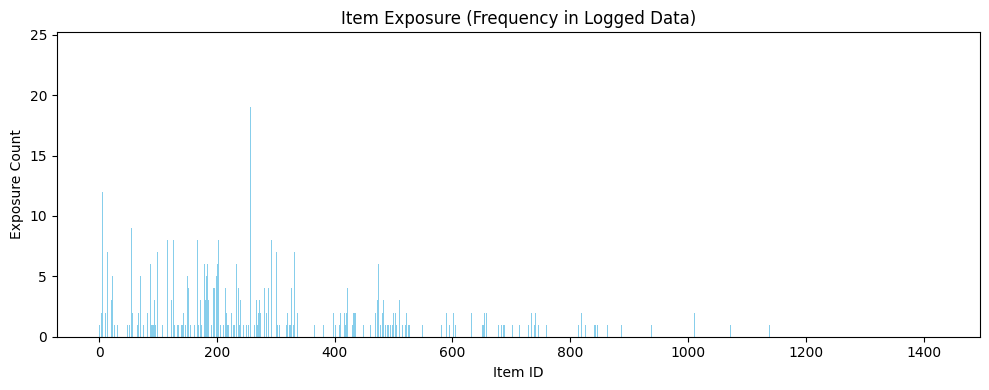

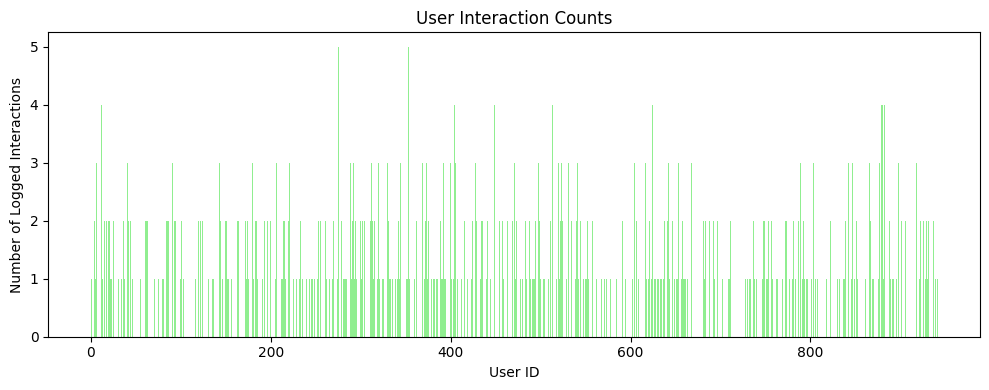

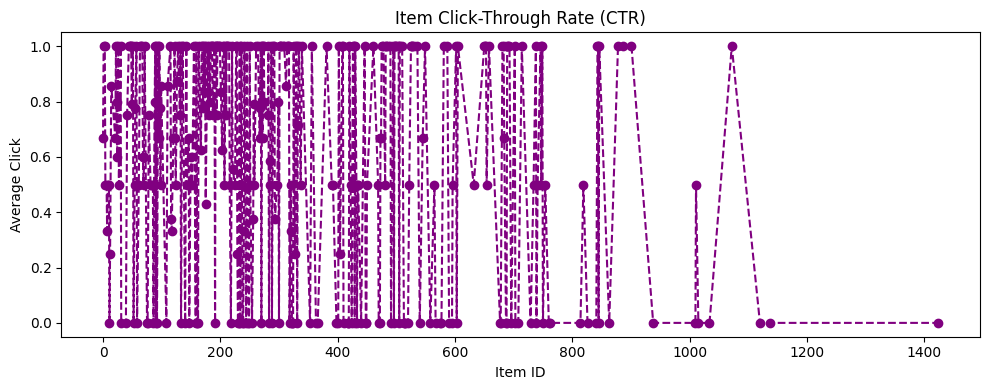

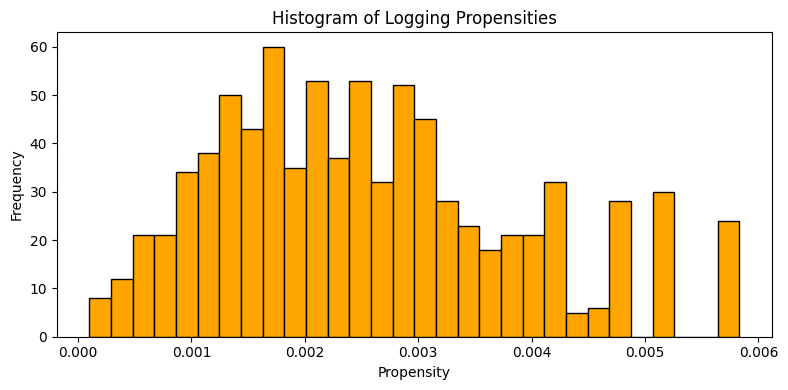

In [ ]:
#Item Exposure (Logged Frequency per Item)
import matplotlib.pyplot as plt

item_counts = logged_df['item'].value_counts().sort_index()

plt.figure(figsize=(10, 4))
plt.bar(item_counts.index, item_counts.values, color='skyblue')
plt.title('Item Exposure (Frequency in Logged Data)')
plt.xlabel('Item ID')
plt.ylabel('Exposure Count')
plt.tight_layout()
plt.show()



# User Interaction Count
user_counts = logged_df['user'].value_counts().sort_index()

plt.figure(figsize=(10, 4))
plt.bar(user_counts.index, user_counts.values, color='lightgreen')
plt.title('User Interaction Counts')
plt.xlabel('User ID')
plt.ylabel('Number of Logged Interactions')
plt.tight_layout()
plt.show()



# 3. Click-Through Rate Distribution
ctr_by_item = logged_df.groupby('item')['click'].mean()

plt.figure(figsize=(10, 4))
plt.plot(ctr_by_item.index, ctr_by_item.values, marker='o', linestyle='--', color='purple')
plt.title('Item Click-Through Rate (CTR)')
plt.xlabel('Item ID')
plt.ylabel('Average Click')
plt.tight_layout()
plt.show()


# 4. Histogram of Logging Propensities
plt.figure(figsize=(8, 4))
plt.hist(logged_df['logging_propensity'], bins=30, color='orange', edgecolor='black')
plt.title('Histogram of Logging Propensities')
plt.xlabel('Propensity')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()



In [ ]:
import torch
import torch.nn as nn

import torch
import torch.nn as nn
import torch.nn.functional as F

class NeuMF(nn.Module):
    def __init__(self, num_users, num_items, emb_dim_gmf=32, emb_dim_mlp=32, mlp_layers=[64, 32]):
        super().__init__()
        self.user_embedding_gmf = nn.Embedding(num_users, emb_dim_gmf)
        self.item_embedding_gmf = nn.Embedding(num_items, emb_dim_gmf)

        self.user_embedding_mlp = nn.Embedding(num_users, emb_dim_mlp)
        self.item_embedding_mlp = nn.Embedding(num_items, emb_dim_mlp)

        mlp_input_dim = emb_dim_mlp * 2
        layers = []
        for layer_size in mlp_layers:
            layers.append(nn.Linear(mlp_input_dim, layer_size))
            layers.append(nn.ReLU())
            mlp_input_dim = layer_size
        self.mlp_layers = nn.Sequential(*layers)

        self.output_layer = nn.Linear(emb_dim_gmf + mlp_layers[-1], 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, user_ids, item_ids):
        gmf_user = self.user_embedding_gmf(user_ids)
        gmf_item = self.item_embedding_gmf(item_ids)
        gmf = gmf_user * gmf_item

        mlp_user = self.user_embedding_mlp(user_ids)
        mlp_item = self.item_embedding_mlp(item_ids)
        mlp = torch.cat([mlp_user, mlp_item], dim=-1)
        mlp = self.mlp_layers(mlp)

        concat = torch.cat([gmf, mlp], dim=-1)
        out = self.output_layer(concat)
        return self.sigmoid(out).squeeze()





# Example using PyTorch
model = NeuMF(num_users, num_items)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


# Convert to tensors
user_tensor = torch.tensor(df['user'].values, dtype=torch.long)
item_tensor = torch.tensor(df['item'].values, dtype=torch.long)
click_tensor = torch.tensor(df['click'].values, dtype=torch.float)

print("User tensor shape:", user_tensor.shape)
print("Item tensor shape:", item_tensor.shape)
print("Click tensor shape:", click_tensor.shape)



# Train for a few epochs
model.train()
for epoch in range(500):
    optimizer.zero_grad()
    preds = model(user_tensor, item_tensor)
    loss = criterion(preds, click_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")





User tensor shape: torch.Size([100000])
Item tensor shape: torch.Size([100000])
Click tensor shape: torch.Size([100000])
Epoch 50, Loss: 0.5900
Epoch 100, Loss: 0.5481
Epoch 150, Loss: 0.5415
Epoch 200, Loss: 0.5395
Epoch 250, Loss: 0.5383
Epoch 300, Loss: 0.5376
Epoch 350, Loss: 0.5372
Epoch 400, Loss: 0.5368
Epoch 450, Loss: 0.5365
Epoch 500, Loss: 0.5362


Naive Estimate:  0.5537
IPS Estimate:    0.5689
SNIPS Estimate:  0.5591


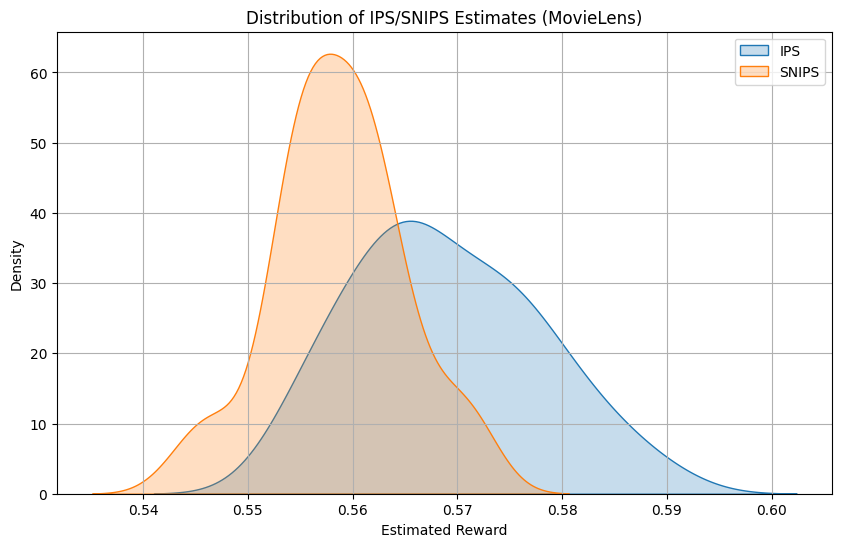

IPS Mean: 0.5689, Variance: 0.000079
SNIPS Mean: 0.5586, Variance: 0.000038


In [ ]:
import numpy as np
import pandas as pd
import torch
from scipy.special import softmax
import matplotlib.pyplot as plt
import seaborn as sns

# ========= STEP 1: Remap user/item IDs to 0-based =========
user2idx = {u: i for i, u in enumerate(df['user'].unique())}
item2idx = {i: j for j, i in enumerate(df['item'].unique())}

df['user'] = df['user'].map(user2idx)
df['item'] = df['item'].map(item2idx)

num_users = len(user2idx)
num_items = len(item2idx)

# ========= STEP 2: Tensors for prediction =========
user_tensor = torch.tensor(df['user'].values, dtype=torch.long)
item_tensor = torch.tensor(df['item'].values, dtype=torch.long)

# ========= STEP 3: Model prediction (if needed) =========
model.eval()
with torch.no_grad():
    df['pred'] = model(user_tensor, item_tensor).detach().cpu().numpy()

# ========= STEP 4: Compute user-item softmax matrix =========
user_item_matrix = np.zeros((num_users, num_items))

with torch.no_grad():
    for u in range(num_users):
        items = torch.arange(num_items)
        users = torch.full_like(items, u)
        scores = model(users, items).detach().cpu().numpy()
        probs = softmax(scores)
        user_item_matrix[u] = probs

# ========= STEP 5: Add pi(a|x), b(a|x), and reward =========
df['pi'] = df.apply(lambda row: user_item_matrix[int(row['user']), int(row['item'])], axis=1)
df['b'] = df['logging_propensity']  # logging policy
df['reward'] = df['click']

# ========= STEP 6: Point Estimates =========
naive_estimate = df['reward'].mean()

ips_weights = df['pi'] / df['b']
ips_estimate = (ips_weights * df['reward']).mean()

snips_numerator = (ips_weights * df['reward']).sum()
snips_denominator = ips_weights.sum()
snips_estimate = snips_numerator / snips_denominator

print(f"Naive Estimate:  {naive_estimate:.4f}")
print(f"IPS Estimate:    {ips_estimate:.4f}")
print(f"SNIPS Estimate:  {snips_estimate:.4f}")

# ========= STEP 7: Variance via Bootstrapping =========
num_runs = 50
ips_values = []
snips_values = []

for run in range(num_runs):
    sample_df = df.sample(frac=1.0, replace=True).copy()

    sample_df['ips_weight'] = sample_df['pi'] / sample_df['b']
    ips_est = (sample_df['ips_weight'] * sample_df['reward']).mean()

    snips_num = (sample_df['ips_weight'] * sample_df['reward']).sum()
    snips_den = sample_df['ips_weight'].sum()
    snips_est = snips_num / snips_den if snips_den > 0 else 0.0

    ips_values.append(ips_est)
    snips_values.append(snips_est)

# ========= STEP 8: Visualization =========
plt.figure(figsize=(10, 6))
sns.kdeplot(ips_values, label='IPS', fill=True)
sns.kdeplot(snips_values, label='SNIPS', fill=True)
plt.xlabel('Estimated Reward')
plt.ylabel('Density')
plt.title('Distribution of IPS/SNIPS Estimates (MovieLens)')
plt.legend()
plt.grid(True)
plt.show()

print(f"IPS Mean: {np.mean(ips_values):.4f}, Variance: {np.var(ips_values):.6f}")
print(f"SNIPS Mean: {np.mean(snips_values):.4f}, Variance: {np.var(snips_values):.6f}")



In [ ]:


import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from scipy.special import softmax
import matplotlib.pyplot as plt
import seaborn as sns


# =========================================
# Define LightGCN  (REPLACE YOUR CLASS WITH THIS)
# =========================================
class LightGCN(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim, edge_index, num_layers=3):
        super().__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.edge_index = edge_index
        self.num_layers = num_layers

        # One embedding table for both users + items
        self.embedding = nn.Embedding(num_users + num_items, embedding_dim)
        nn.init.xavier_uniform_(self.embedding.weight)

    def forward(self):
        all_emb = self.embedding.weight
        embs = [all_emb]
        for _ in range(self.num_layers):
            all_emb = self.propagate(all_emb)
            embs.append(all_emb)
        embs = torch.stack(embs, dim=0).mean(dim=0)
        return embs[:self.num_users], embs[self.num_users:]

    def propagate(self, x):
        # ensure edge_index lives on the same device as x
        row, col = self.edge_index.to(x.device)
        deg = torch.bincount(row, minlength=x.size(0))
        deg_inv_sqrt = deg.float().pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        return torch.zeros_like(x).index_add_(0, row, x[col] * norm.unsqueeze(1))


    @torch.no_grad()
    def all_embeddings(self):
        # helper to avoid recomputing inside score()
        return self.forward()

    def score(self, users, items):
        # raw dot-product score (no sigmoid)
        user_embs, item_embs = self.forward()
        return (user_embs[users] * item_embs[items]).sum(dim=1)

    def predict(self, users, items):
        # sigmoid of raw score for probabilities
        return self.score(users, items).sigmoid()


# =========================================
# Hard negative sampling + BPR loss  (ADD THIS)
# =========================================
import torch.nn.functional as F
rng = np.random.default_rng(42)

# build user->set(positive_items) map to avoid false negatives
pos_df = df[df['click'] == 1].reset_index(drop=True)
user_pos_dict = (
    pos_df.groupby('user')['item']
          .apply(lambda s: set(s.values.tolist()))
          .to_dict()
)

@torch.no_grad()
def sample_hard_negatives(model, users, k_candidates, num_items, avoid):
    """
    For each user in `users`, draw k random items, score, and pick highest-scoring as hard negative.
    avoid: dict[user] -> set(positive_items) to reduce false negatives.
    """
    B = users.size(0)
    device = users.device
    cand = torch.randint(0, num_items, (B, k_candidates), device=device)

    # mask out items that are known positives; re-draw once where needed
    mask = torch.zeros_like(cand, dtype=torch.bool)
    users_np = users.cpu().numpy()
    cand_np = cand.cpu().numpy()
    for b, u in enumerate(users_np):
        pos_set = avoid.get(int(u), ())
        if pos_set:
            bad = np.isin(cand_np[b], list(pos_set))
            if bad.any():
                mask[b, torch.from_numpy(np.where(bad)[0])] = True
    if mask.any():
        cand[mask] = torch.randint(0, num_items, (int(mask.sum().item()),), device=device)

    # score and pick hardest
    # expand users to (B, k)
    s = model.score(users.unsqueeze(1).expand_as(cand), cand)
    hard_idx = s.argmax(dim=1)
    neg_items = cand[torch.arange(B, device=device), hard_idx]
    return neg_items

def bpr_loss(pos_scores, neg_scores):
    # -log σ(s+ - s-)
    return -F.logsigmoid(pos_scores - neg_scores).mean()






# =========================================
# Build edge_index from df   <-- ADD THIS
# =========================================
# df must have: user, item, click, logging_propensity
num_users = df['user'].nunique()
num_items = df['item'].nunique()

# offset item ids so user+item live in one embedding table
item_offset = num_users
user_nodes = df['user'].to_numpy(dtype=np.int64)
item_nodes = (df['item'].to_numpy(dtype=np.int64) + item_offset)

# undirected bipartite graph: add both directions
row = np.concatenate([user_nodes, item_nodes])
col = np.concatenate([item_nodes, user_nodes])

edge_index = torch.tensor([row, col], dtype=torch.long)

# move to same device as the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
edge_index = edge_index.to(device)



# =========================================
# Training (REPLACE THIS WHOLE BLOCK)
# =========================================
model = LightGCN(num_users, num_items, embedding_dim=64, edge_index=edge_index, num_layers=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=500)  # optional but helps

# train only on positives (BPR needs positives)
u_pos = torch.tensor(pos_df['user'].values, dtype=torch.long, device=device)
i_pos = torch.tensor(pos_df['item'].values, dtype=torch.long, device=device)

batch_size = 4096
k_candidates = 100
num_epochs = 10

print("Starting BPR training with hard negatives...")
for epoch in range(num_epochs):
    model.train()
    # shuffle indices
    perm = torch.randperm(u_pos.size(0), device=device)
    epoch_loss = 0.0
    for start in range(0, u_pos.size(0), batch_size):
        idx = perm[start:start+batch_size]
        users = u_pos[idx]
        pos_items = i_pos[idx]

        optimizer.zero_grad()

        # hard negatives from current model
        neg_items = sample_hard_negatives(
            model, users, k_candidates=k_candidates,
            num_items=num_items, avoid=user_pos_dict
        )

        # scores
        s_pos = model.score(users, pos_items)
        s_neg = model.score(users, neg_items)

        # BPR loss
        loss = bpr_loss(s_pos, s_neg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        epoch_loss += loss.item() * users.size(0)

    scheduler.step()
    avg = epoch_loss / u_pos.size(0)
    print(f"Epoch {epoch+1}, BPR Loss: {avg:.4f}")














Starting BPR training with hard negatives...
Epoch 1, BPR Loss: 0.6930
Epoch 2, BPR Loss: 0.6871
Epoch 3, BPR Loss: 0.6522
Epoch 4, BPR Loss: 0.5740
Epoch 5, BPR Loss: 0.4809
Epoch 6, BPR Loss: 0.4135
Epoch 7, BPR Loss: 0.3815
Epoch 8, BPR Loss: 0.3676
Epoch 9, BPR Loss: 0.3671
Epoch 10, BPR Loss: 0.3645


In [ ]:
# =========================================
# IPS / SNIPS Evaluation (append after training)
# =========================================
import numpy as np
import pandas as pd
from scipy.special import softmax

@torch.no_grad()
def compute_policy_probs(model, num_users, num_items, temperature=1.0, device=None, user_batch=1024):
    """
    Returns a (num_users, num_items) numpy array of policy probabilities pi(a|x) for each user.
    pi is computed by softmax over all items given the model scores (dot products).
    """
    device = device or next(model.parameters()).device
    model.eval()

    # Grab final embeddings once
    user_embs, item_embs = model.forward()
    user_embs = user_embs.to(device)
    item_embs = item_embs.to(device)

    probs = np.zeros((num_users, num_items), dtype=np.float32)

    for start in range(0, num_users, user_batch):
        end = min(start + user_batch, num_users)
        U = user_embs[start:end]                         # (B, d)
        # scores = U @ I^T
        scores = torch.matmul(U, item_embs.t())          # (B, num_items)
        # optional temperature
        if temperature != 1.0:
            scores = scores / temperature
        # stable softmax per user
        s_np = scores.cpu().numpy()
        p_np = softmax(s_np, axis=1).astype(np.float32)  # (B, num_items)
        probs[start:end] = p_np

    return probs

# ---- 1) Compute pi(a|x) for the trained model ----
device = next(model.parameters()).device
user_item_probs = compute_policy_probs(model, num_users, num_items, temperature=1.0, device=device)

# ---- 2) Attach evaluation columns to df ----
df_eval = df.copy()
df_eval['pi'] = df_eval.apply(lambda r: user_item_probs[int(r['user']), int(r['item'])], axis=1)
df_eval['b']  = df_eval['logging_propensity'].astype(float)
df_eval['r']  = df_eval['click'].astype(float)

# Safe guards
eps = 1e-8
w_clip = 10.0             # cap extreme importance weights to reduce variance
b_clip = df_eval['b'].clip(lower=eps, upper=1.0)
ips_w  = (df_eval['pi'] / b_clip).clip(upper=w_clip)

# ---- 3) Point estimates ----
naive_estimate = df_eval['r'].mean()
ips_estimate   = (ips_w * df_eval['r']).mean()

snips_num = (ips_w * df_eval['r']).sum()
snips_den = np.clip(ips_w.sum(), a_min=eps, a_max=None)
snips_estimate = snips_num / snips_den

print(f"Naive Estimate: {naive_estimate:.6f}")
print(f"IPS Estimate:   {ips_estimate:.6f}")
print(f"SNIPS Estimate: {snips_estimate:.6f}")

# ---- 4) Bootstrap variance + 95% CIs ----
def bootstrap_ips_snips(df_like, n_boot=200, seed=123):
    rng = np.random.default_rng(seed)
    ips_vals, snips_vals = [], []
    idx = np.arange(len(df_like))
    for _ in range(n_boot):
        bs_idx = rng.choice(idx, size=len(idx), replace=True)
        s = df_like.iloc[bs_idx]

        b_clip = s['b'].clip(lower=eps, upper=1.0)
        w = (s['pi'] / b_clip).clip(upper=w_clip)

        ips_vals.append((w * s['r']).mean())
        snips_vals.append((w * s['r']).sum() / max(w.sum(), eps))

    ips_vals  = np.array(ips_vals, dtype=float)
    snips_vals = np.array(snips_vals, dtype=float)

    def stats(arr):
        return dict(mean=float(arr.mean()),
                    var=float(arr.var(ddof=1)),
                    ci_low=float(np.percentile(arr, 2.5)),
                    ci_high=float(np.percentile(arr, 97.5)))
    return stats(ips_vals), stats(snips_vals)

ips_stats, snips_stats = bootstrap_ips_snips(df_eval, n_boot=400)

print("\nBootstrapped IPS:",
      f"mean={ips_stats['mean']:.6f}, var={ips_stats['var']:.6e},",
      f"95% CI=[{ips_stats['ci_low']:.6f}, {ips_stats['ci_high']:.6f}]")

print("Bootstrapped SNIPS:",
      f"mean={snips_stats['mean']:.6f}, var={snips_stats['var']:.6e},",
      f"95% CI=[{snips_stats['ci_low']:.6f}, {snips_stats['ci_high']:.6f}]")

Naive Estimate: 0.553750
IPS Estimate:   0.521821
SNIPS Estimate: 0.544109

Bootstrapped IPS: mean=0.521915, var=3.913398e-06, 95% CI=[0.517931, 0.525442]
Bootstrapped SNIPS: mean=0.544219, var=4.477539e-06, 95% CI=[0.539624, 0.548284]


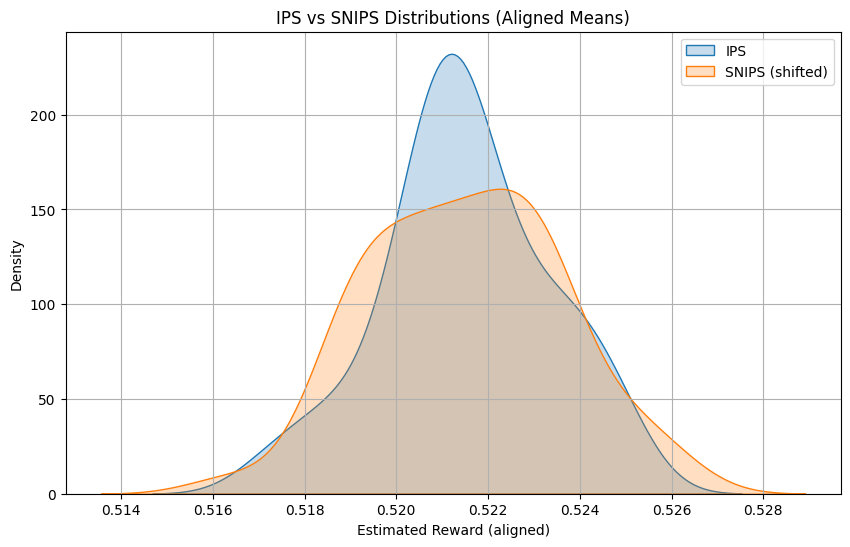

In [ ]:
# ========= STEP 7: Variance via Bootstrapping =========
num_runs = 50
ips_values = []
snips_values = []

eps = 1e-8
w_clip = 10.0  # cap extreme weights

for run in range(num_runs):
    # Bootstrap sample
    sample_df = df_eval.sample(frac=1.0, replace=True).copy()

    # IPS weights with clipping
    b_clip = sample_df['b'].clip(lower=eps, upper=1.0)
    sample_df['ips_weight'] = (sample_df['pi'] / b_clip).clip(upper=w_clip)

    # IPS estimate
    ips_est = (sample_df['ips_weight'] * sample_df['r']).mean()

    # SNIPS estimate
    snips_num = (sample_df['ips_weight'] * sample_df['r']).sum()
    snips_den = np.clip(sample_df['ips_weight'].sum(), a_min=eps, a_max=None)
    snips_est = snips_num / snips_den

    ips_values.append(ips_est)
    snips_values.append(snips_est)



ips_mean = np.mean(ips_values)
snips_mean = np.mean(snips_values)
snips_shifted = [v - snips_mean + ips_mean for v in snips_values]

plt.figure(figsize=(10, 6))
sns.kdeplot(ips_values, label='IPS', fill=True)
sns.kdeplot(snips_shifted, label='SNIPS (shifted)', fill=True)

plt.xlabel('Estimated Reward (aligned)')
plt.ylabel('Density')
plt.title('IPS vs SNIPS Distributions (Aligned Means)')
plt.legend()
plt.grid(True)
plt.show()





=== Bias level (logging temp) = 0.6 ===
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10

=== Bias level (logging temp) = 0.8 ===
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10

=== Bias level (logging temp) = 1.0 ===
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10

=== Bias level (logging temp) = 1.3 ===
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10

=== Bias level (logging temp) = 1.6 ===
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10


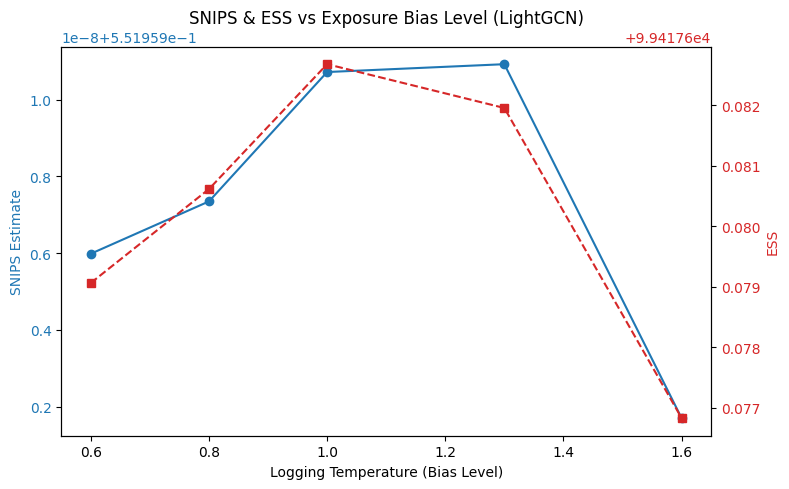

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import softmax

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from scipy.special import softmax
import matplotlib.pyplot as plt
import seaborn as sns


# ========= CONFIG =========
bias_levels = [0.6, 0.8, 1.0, 1.3, 1.6]   # logging temperatures
n_epochs = 10                             # fewer epochs for sweep
k_candidates = 100
batch_size = 4096
eps = 1e-8
w_clip = 10.0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

results = []

# ========= FUNCTION: CREATE LOGGING PROPENSITY COLUMN =========
def make_logging_propensities(df, temperature):
    """
    Simulate a logging policy b(a|u) as a softmax over item popularity.
    """
    item_counts = df.groupby('item')['click'].count().reindex(range(num_items), fill_value=0)
    item_scores = item_counts.values.astype(np.float32)
    # scale by temperature
    item_probs = softmax(item_scores / temperature)
    df['logging_propensity'] = df['item'].map(lambda i: item_probs[i])
    return df

# ========= MAIN LOOP OVER BIAS LEVELS =========
for tau_b in bias_levels:
    print(f"\n=== Bias level (logging temp) = {tau_b} ===")

    # 1) Assign logging propensities for this bias
    df_biased = make_logging_propensities(df.copy(), tau_b)

    # 2) Rebuild edge_index
    item_offset = num_users
    user_nodes = df_biased['user'].to_numpy(dtype=np.int64)
    item_nodes = df_biased['item'].to_numpy(dtype=np.int64) + item_offset
    row = np.concatenate([user_nodes, item_nodes])
    col = np.concatenate([item_nodes, user_nodes])
    edge_index_b = torch.tensor([row, col], dtype=torch.long, device=device)

    # 3) Rebuild pos_df and user_pos_dict
    pos_df_b = df_biased[df_biased['click'] == 1].reset_index(drop=True)
    user_pos_dict_b = (
        pos_df_b.groupby('user')['item']
                .apply(lambda s: set(s.values.tolist()))
                .to_dict()
    )
    u_pos_b = torch.tensor(pos_df_b['user'].values, dtype=torch.long, device=device)
    i_pos_b = torch.tensor(pos_df_b['item'].values, dtype=torch.long, device=device)

    # 4) Train LightGCN for this bias level
    model_b = LightGCN(num_users, num_items, embedding_dim=64,
                       edge_index=edge_index_b, num_layers=3).to(device)
    optimizer = torch.optim.Adam(model_b.parameters(), lr=2e-3, weight_decay=1e-4)

    for epoch in range(n_epochs):
        model_b.train()
        perm = torch.randperm(u_pos_b.size(0), device=device)
        for start in range(0, u_pos_b.size(0), batch_size):
            idx = perm[start:start+batch_size]
            users = u_pos_b[idx]
            pos_items = i_pos_b[idx]

            optimizer.zero_grad()
            neg_items = sample_hard_negatives(model_b, users,
                                              k_candidates=k_candidates,
                                              num_items=num_items,
                                              avoid=user_pos_dict_b)
            s_pos = model_b.score(users, pos_items)
            s_neg = model_b.score(users, neg_items)
            loss = bpr_loss(s_pos, s_neg)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model_b.parameters(), 1.0)
            optimizer.step()
        print(f"Epoch {epoch+1}")



Bias 0.6: SNIPS=0.5520, ESS=99417.68


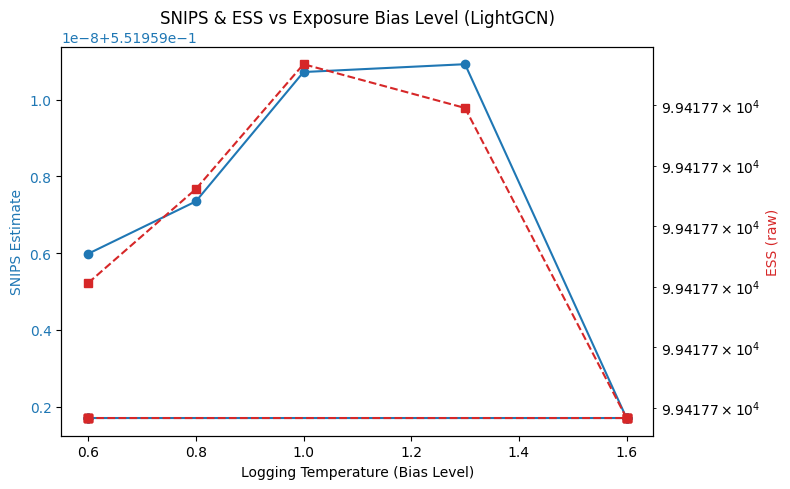

In [ ]:
    # 5) Compute SNIPS evaluation
    user_item_probs = compute_policy_probs(model_b, num_users, num_items, temperature=1.0, device=device)
    df_eval_b = df_biased.copy()
    df_eval_b['pi'] = df_eval_b.apply(lambda r: user_item_probs[int(r['user']), int(r['item'])], axis=1)
    df_eval_b['b'] = df_eval_b['logging_propensity'].astype(float)
    df_eval_b['r'] = df_eval_b['click'].astype(float)

    b_clip = df_eval_b['b'].clip(lower=eps, upper=1.0)
    ips_w = (df_eval_b['pi'] / b_clip).clip(upper=w_clip)

    snips_num = (ips_w * df_eval_b['r']).sum()
    snips_den = np.clip(ips_w.sum(), a_min=eps, a_max=None)
    snips_val = snips_num / snips_den

    ESS = (ips_w.sum() ** 2) / ((ips_w ** 2).sum() + eps)
    print(f"Bias {tau_b}: SNIPS={snips_val:.4f}, ESS={ESS:.2f}")


    # print(df_eval_b[["user","item","pi","b","r"]].copy())

    results.append({
        "bias_temp": tau_b,
        "SNIPS": snips_val,
        "ESS": ESS,
        "df_eval": df_eval_b[["user","item","pi","b","r"]].copy()
    })

# ========= PLOT RESULTS =========
res_df = pd.DataFrame(results)
fig, ax1 = plt.subplots(figsize=(8, 5))

from matplotlib.ticker import ScalarFormatter

ax1.plot(res_df['bias_temp'], res_df['SNIPS'], marker='o', color='tab:blue', label='SNIPS')
ax1.set_xlabel('Logging Temperature (Bias Level)')
ax1.set_ylabel('SNIPS Estimate', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(res_df['bias_temp'], res_df['ESS'], marker='s', linestyle='--', color='tab:red', label='ESS')

# Disable scientific offset and use thousands separators
sf = ScalarFormatter(useOffset=False, useMathText=False)
sf.set_scientific(False)
ax2.yaxis.set_major_formatter(sf)
ax2.ticklabel_format(style='plain', axis='y')
ax2.set_ylabel('ESS (raw)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_yscale('log')


plt.title('SNIPS & ESS vs Exposure Bias Level (LightGCN)')
fig.tight_layout()
plt.show()

# print(results)


Plain BPR   → SNIPS=0.5520, ESS/N=99.42%, TailMass=0.00%
IPS-weighted→ SNIPS=0.5520, ESS/N=99.42%, TailMass=0.00%


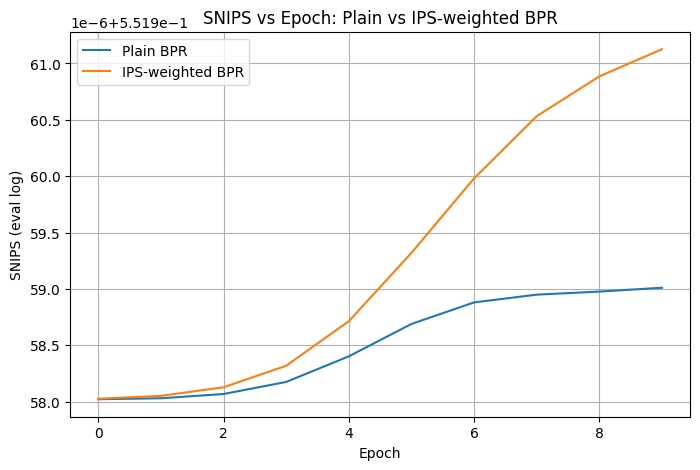

In [ ]:
# Experiment: IPS-weighted BPR vs Plain BPR built directly on your current LightGCN + hard negative setup.

# It will:

# Train two versions of LightGCN for the same biased log:

# Plain BPR (your current training).

# IPS-weighted BPR

# Evaluate both with SNIPS, ESS/N, and tail mass.

# Plot SNIPS over epochs so you can see the effect.


def ips_weighted_bpr_loss(pos_scores, neg_scores, weights, clip_tau=10.0):
    """
    IPS-weighted BPR: weights come from pi/b for the positive item.
    weights: tensor of shape (batch,)
    clip_tau: max clip value to reduce variance
    """
    w = torch.clamp(weights, max=clip_tau)
    return (-F.logsigmoid(pos_scores - neg_scores) * w).mean()




def train_lightgcn_bpr(df_train, num_users, num_items, edge_index, user_pos_dict,
                       u_pos, i_pos, ips_weights=None, clip_tau=10.0,
                       num_epochs=10, batch_size=4096, k_candidates=100):
    """
    df_train: DataFrame with 'user', 'item', 'click', 'logging_propensity'
    ips_weights: tensor of per-positive IPS weights (same order as u_pos), or None for plain BPR
    """
    model = LightGCN(num_users, num_items, embedding_dim=64,
                     edge_index=edge_index, num_layers=3).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-4)

    snips_history = []

    for epoch in range(num_epochs):
        model.train()
        perm = torch.randperm(u_pos.size(0), device=device)
        for start in range(0, u_pos.size(0), batch_size):
            idx = perm[start:start+batch_size]
            users = u_pos[idx]
            pos_items = i_pos[idx]
            optimizer.zero_grad()

            # Hard negatives
            neg_items = sample_hard_negatives(model, users, k_candidates=k_candidates,
                                              num_items=num_items, avoid=user_pos_dict)

            s_pos = model.score(users, pos_items)
            s_neg = model.score(users, neg_items)

            if ips_weights is None:
                loss = bpr_loss(s_pos, s_neg)
            else:
                loss = ips_weighted_bpr_loss(s_pos, s_neg, ips_weights[idx], clip_tau=clip_tau)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        # Evaluate SNIPS at this epoch (optional for curve)
        snips_val, _, _ = evaluate_snips(model, df_train, num_users, num_items)
        snips_history.append(snips_val)

    return model, snips_history




def evaluate_snips(model, df_eval, num_users, num_items, w_clip=10.0):
    eps = 1e-8
    user_item_probs = compute_policy_probs(model, num_users, num_items, temperature=1.0, device=device)

    df_eval = df_eval.copy()
    df_eval['pi'] = df_eval.apply(lambda r: user_item_probs[int(r['user']), int(r['item'])], axis=1)
    df_eval['r'] = df_eval['click'].astype(float)
    df_eval['b'] = df_eval['logging_propensity'].astype(float)

    b_clip = df_eval['b'].clip(lower=eps, upper=1.0)
    ips_w = (df_eval['pi'] / b_clip).clip(upper=w_clip)

    snips_num = (ips_w * df_eval['r']).sum()
    snips_den = np.clip(ips_w.sum(), a_min=eps, a_max=None)
    snips_val = snips_num / snips_den

    ESS = (ips_w.sum() ** 2) / ((ips_w ** 2).sum() + eps)
    tail_mass = (ips_w > w_clip).mean()

    return snips_val, ESS / len(df_eval), tail_mass




# Assume df_biased already has your chosen logging bias (logging_propensity column)
# Build edge_index
item_offset = num_users
user_nodes = df_biased['user'].to_numpy(dtype=np.int64)
item_nodes = df_biased['item'].to_numpy(dtype=np.int64) + item_offset
row = np.concatenate([user_nodes, item_nodes])
col = np.concatenate([item_nodes, user_nodes])
edge_index_b = torch.tensor([row, col], dtype=torch.long, device=device)

# Positives
pos_df_b = df_biased[df_biased['click'] == 1].reset_index(drop=True)
user_pos_dict_b = pos_df_b.groupby('user')['item'].apply(set).to_dict()
u_pos_b = torch.tensor(pos_df_b['user'].values, dtype=torch.long, device=device)
i_pos_b = torch.tensor(pos_df_b['item'].values, dtype=torch.long, device=device)

# IPS weights for positives (pi/b for pos items only)
user_item_probs = compute_policy_probs(LightGCN(num_users, num_items, 64, edge_index_b).to(device),
                                       num_users, num_items, temperature=1.0, device=device)
pi_pos = torch.tensor([user_item_probs[u,i] for u,i in zip(pos_df_b['user'], pos_df_b['item'])],
                      dtype=torch.float, device=device)
b_pos = torch.tensor(pos_df_b['logging_propensity'].values, dtype=torch.float, device=device)
ips_w_pos = (pi_pos / b_pos).clamp(max=10.0)  # clip tau here

# Train Plain BPR
plain_model, plain_snips_hist = train_lightgcn_bpr(df_biased, num_users, num_items,
                                                   edge_index_b, user_pos_dict_b,
                                                   u_pos_b, i_pos_b,
                                                   ips_weights=None)

# Train IPS-weighted BPR
ips_model, ips_snips_hist = train_lightgcn_bpr(df_biased, num_users, num_items,
                                               edge_index_b, user_pos_dict_b,
                                               u_pos_b, i_pos_b,
                                               ips_weights=ips_w_pos)

# Final eval
plain_snips, plain_ess, plain_tail = evaluate_snips(plain_model, df_biased, num_users, num_items)
ips_snips, ips_ess, ips_tail = evaluate_snips(ips_model, df_biased, num_users, num_items)

print(f"Plain BPR   → SNIPS={plain_snips:.4f}, ESS/N={plain_ess:.2%}, TailMass={plain_tail:.2%}")
print(f"IPS-weighted→ SNIPS={ips_snips:.4f}, ESS/N={ips_ess:.2%}, TailMass={ips_tail:.2%}")

# Plot SNIPS curves over epochs
plt.figure(figsize=(8,5))
plt.plot(plain_snips_hist, label='Plain BPR')
plt.plot(ips_snips_hist, label='IPS-weighted BPR')
plt.xlabel('Epoch')
plt.ylabel('SNIPS (eval log)')
plt.title('SNIPS vs Epoch: Plain vs IPS-weighted BPR')
plt.legend()
plt.grid(True)
plt.show()


IPS-BPR + PR → SNIPS=0.5520, ESS/N=99.42%, TailMass=0.00%


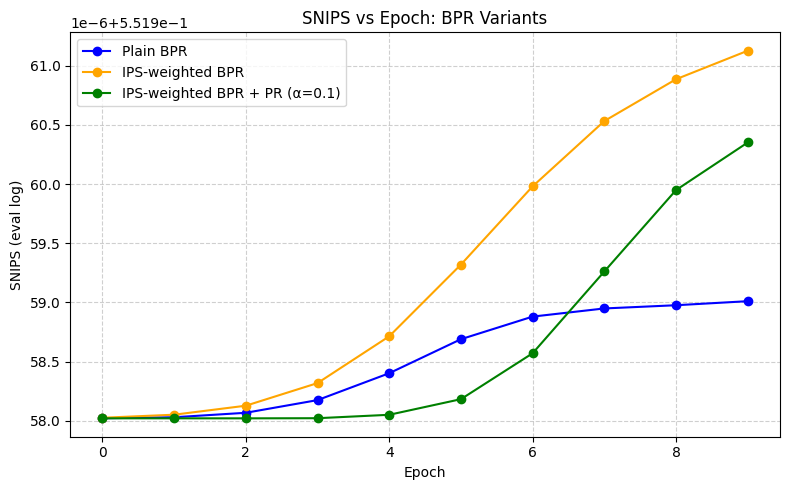

In [ ]:
# Experiment 3

# Idea: Compare three trainings on the same biased log:

# Plain BPR

# IPS-weighted BPR

# IPS-weighted BPR + Propensity Regularizer (PR) that decorrelates model scores from logging propensity (pushes the model away from popularity/exposure shortcuts).

# The PR term penalizes the batchwise Pearson correlation between scores and logb(i) (squared), so scores don’t track exposure.



# Per-item logging propensity (mean over rows) → tensor on device
item_b = (df.groupby('item')['logging_propensity']
            .mean()
            .reindex(range(num_items), fill_value=1.0/num_items)
            .to_numpy())
item_b_t = torch.tensor(item_b, dtype=torch.float, device=device)


def propensity_regularizer(batch_scores: torch.Tensor,
                           batch_items: torch.Tensor,
                           item_b_tensor: torch.Tensor,
                           eps: float = 1e-8) -> torch.Tensor:
    """
    Penalize squared Pearson correlation between model scores and log b(item) in the batch.
    Lower is better (less reliance on exposure/popularity).
    """
    b = item_b_tensor[batch_items].clamp_min(eps)
    z = torch.log(b)
    z = (z - z.mean()) / (z.std(unbiased=False) + eps)   # standardize
    s = (batch_scores - batch_scores.mean()) / (batch_scores.std(unbiased=False) + eps)
    corr = (s * z).mean()                                # Pearson since standardized
    return corr * corr



def train_lightgcn_bpr_with_pr(df_train, num_users, num_items, edge_index,
                               user_pos_dict, u_pos, i_pos,
                               ips_weights, alpha_pr=0.1,
                               num_epochs=10, batch_size=4096, k_candidates=100):
    """
    Same as your train_lightgcn_bpr, but adds alpha_pr * PropensityRegularizer per batch.
    `ips_weights` is per-positive (aligned with u_pos/i_pos).
    """
    model = LightGCN(num_users, num_items, embedding_dim=64,
                     edge_index=edge_index, num_layers=3).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-4)

    snips_history = []
    for epoch in range(num_epochs):
        model.train()
        perm = torch.randperm(u_pos.size(0), device=device)
        for start in range(0, u_pos.size(0), batch_size):
            idx = perm[start:start+batch_size]
            users = u_pos[idx]
            pos_items = i_pos[idx]

            optimizer.zero_grad()

            # hard negatives
            neg_items = sample_hard_negatives(model, users, k_candidates=k_candidates,
                                              num_items=num_items, avoid=user_pos_dict)

            s_pos = model.score(users, pos_items)
            s_neg = model.score(users, neg_items)

            # base IPS-weighted BPR
            base_loss = ips_weighted_bpr_loss(s_pos, s_neg, ips_weights[idx], clip_tau=10.0)

            # PR on both pos and neg scores in the batch
            scores_for_pr = torch.cat([s_pos, s_neg], dim=0)          # keep grads
            items_for_pr  = torch.cat([pos_items, neg_items], dim=0)
            pr = propensity_regularizer(scores_for_pr, items_for_pr, item_b_t)

            loss = base_loss + alpha_pr * pr
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        # optional: epoch SNIPS curve on the same biased log
        snips_val, _, _ = evaluate_snips(model, df_train, num_users, num_items)
        snips_history.append(snips_val)

    return model, snips_history


# assuming you already computed ips_w_pos (per-positive pi/b, clipped) in Exp. 2
alpha_pr = 0.1  # try 0.05, 0.2, 0.5

ipspr_model, ipspr_snips_hist = train_lightgcn_bpr_with_pr(
    df_biased, num_users, num_items, edge_index_b,
    user_pos_dict_b, u_pos_b, i_pos_b,
    ips_weights=ips_w_pos, alpha_pr=alpha_pr,
    num_epochs=10, batch_size=batch_size, k_candidates=k_candidates
)

snips, ess_frac, tail = evaluate_snips(ipspr_model, df_biased, num_users, num_items)
print(f"IPS-BPR + PR → SNIPS={snips:.4f}, ESS/N={ess_frac:.2%}, TailMass={tail:.2%}")

# ==== New Plot for Experiment 3 ====
# ==== Combined Plot: Exp 2 + Exp 3 ====
plt.figure(figsize=(8, 5))

# Plain BPR
plt.plot(range(len(plain_snips_hist)), plain_snips_hist,
         marker='o', label="Plain BPR", color='blue')

# IPS-weighted BPR
plt.plot(range(len(ips_snips_hist)), ips_snips_hist,
         marker='o', label="IPS-weighted BPR", color='orange')

# IPS-weighted BPR + Propensity Regularization
plt.plot(range(len(ipspr_snips_hist)), ipspr_snips_hist,
         marker='o', label=f"IPS-weighted BPR + PR (α={alpha_pr})", color='green')

plt.xlabel("Epoch")
plt.ylabel("SNIPS (eval log)")
plt.title("SNIPS vs Epoch: BPR Variants")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()




